In [94]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import seaborn
import pickle
import math
from sklearn import linear_model

In [103]:
with open("points_per_polygon.dat") as f:
    polygons = pickle.load(f)
    
total_points = polygons[0].shape[0] + polygons[1].shape[0]    
points = np.zeros((total_points,2))

points[0:polygons[0].shape[0], :] = polygons[0]
points[polygons[0].shape[0]:, :] = polygons[1]

print "points:", points.shape
print polygons[0].shape, polygons[1].shape, "total points:", polygons[0].shape[0] + polygons[1].shape[0]

points: (113, 2)
(44, 2) (69, 2) total points: 113


In [104]:
pts = []
point_ind = 0
point_hash = {}
point_ind_hash = {}


for p in list(points):
    point_tuple = (p[0],p[1])
    pts.append(point_tuple)
    point_hash[point_tuple] = point_ind
    point_ind_hash[point_ind] = point_tuple
    point_ind += 1
    
poly_y = []

for y in xrange(len(polygons)):
    hash_points_in_poly = []
    for p in polygons[y]:
        point = (p[0],p[1])
        hash_points_in_poly.append(point_hash[point])
    poly_y.append(hash_points_in_poly)

113


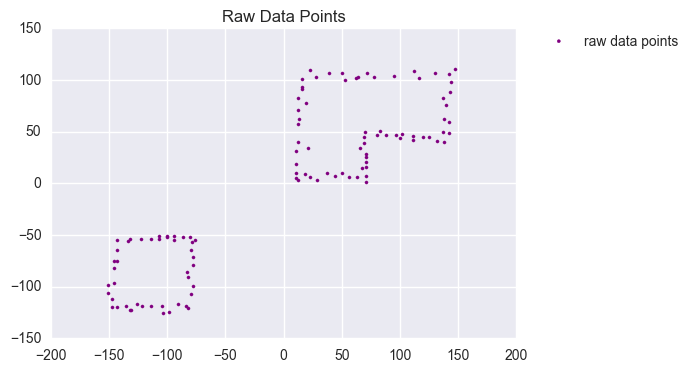

In [97]:
plt.scatter(points[:,0], points[:,1], color='purple', marker='.',
            label='raw data points')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Raw Data Points")
plt.show()

In [161]:
from random import randint

Y = 2             # number of polygons
L = 10            # number of lines (in the whole Map)
P = points.shape[0] # number of Points

                       
def compute_data_likelihood(qs, lines):
    likelihood = 0
    for y in xrange(Y):
        for p, hash_p in enumerate(poly_y[y]):
            l = qs[y][p]
            likelihood += math.log(lines[hash_p][l])
    return likelihood

def resample_qs(qs, c_pl, c_yl):
    for y in xrange(Y):
        for p, hash_p in enumerate(poly_y[y]):
            prob_dist = []
            total = 0
            for l in xrange(L):
                prob = pplm[l][y] * lines[hash_p][l]
                total += prob
                prob_dist.append(prob)
            prob_dist = np.asarray(prob_dist) / total
            
            '''Resample new line for point'''
            new_l = np.random.choice(L, p=prob_dist)
            '''Assign new l to point in polygon'''
            old_l = qs[y][p]
            qs[y][p] = new_l

            '''Update counts c_vk'''
            c_pl[hash_p][old_l] -=1
            c_pl[hash_p][new_l] +=1
            '''Update counts c_ik'''
            c_yl[y][old_l] -=1
            c_yl[y][new_l] +=1
                
    return qs, c_pl, c_yl


def Initialize_qs():
    c = np.zeros((Y,P,L)) #(polygons, points, lines)
    qs = []
    for y in xrange(Y):
        line_in_polygon = []
            #random line
            rand_line = randint(0, L-1)
            line_in_polygon.append(rand_line)
            point = (p[0],p[1])
            c[y, point_hash[point], rand_line] +=1
        qs.append(line_in_polygon)
    return qs, c


'''Initalize PI , c '''
'''
for each polygon, each point has a line assigned 
get the counts c = (polygons , points, lines)
'''

qs, c = Initialize_qs()


'''Collect statistics'''
c_pl = np.sum(c, axis=0) 
c_yl = np.sum(c, axis=1) 
c_l = np.sum(c_pl, axis=0) 
L_y = np.sum(c_yl, axis=1) 

if 1:
    print "len(qs): ", len(qs)
    print "len(qs[0]): ", len(qs[0])
    print "len(qs[1]): ", len(qs[1])
    print "c_pl:", c_pl.shape #(113, 10)
    print "c_yl:", c_yl.shape #(2, 10)
    print "c_l:", c_l.shape   #(10,)
    print "L_y:", L_y.shape   #(2,)


'''[alpha] [beta] hyperparameters'''
alphas = np.ones((L,1))[:,0] #lines
gammas = np.ones((P,1))[:,0] #points


'''[PI] For each polygon, dirichlet distribution over lines'''
# per-polygon-line distributions: 
pplm = np.zeros((L,Y)) # 10, 2
for y in xrange(Y):
    pplm[:,y] = np.random.dirichlet(alphas + c_yl[y])

'''[B] For each line, dirichlet distribution over points'''
# per-line-point distributions: 
lines = np.zeros((P,L)) #113, 10
for l in xrange(L):
    lines[:, l] =  np.random.dirichlet(gammas + c_pl[:,l]) # FREQUENCIES


IndentationError: unexpected indent (<ipython-input-161-a1500fa4f455>, line 49)

100%|██████████| 5000/5000 [00:27<00:00, 182.37it/s]


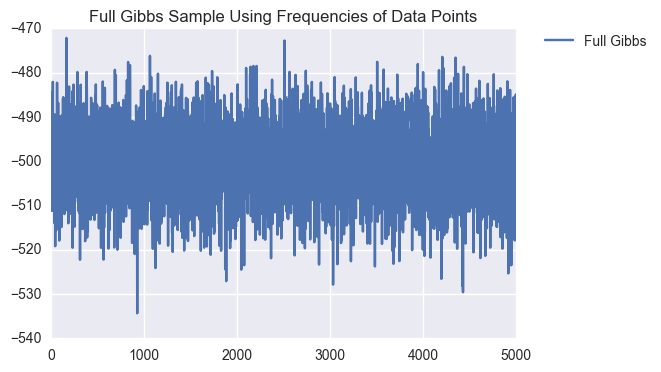

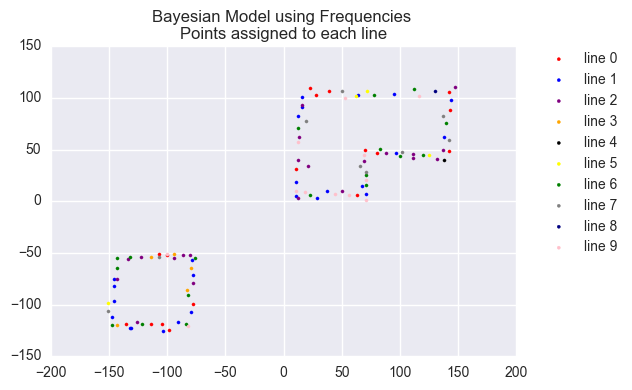

In [162]:
RUNS = 5000
full_gibbs_likelihoods = [] 
for iters in tqdm(range(0,RUNS)):
    # compute data likelihood
    p = compute_data_likelihood(qs, lines)
    
    # store likelihood
    full_gibbs_likelihoods.append(p)
    
    #print "Iter %d, p=%.2f" % (iters,p)
    
    # resample per-point line assignments qs
    qs, c_pl, c_yl = resample_qs(qs, c_pl, c_yl)
 
    # resample per-polygon line mixtures pplm
    for y in xrange(Y):
        pplm[:,y] = np.random.dirichlet(alphas + c_yl[y])
        
    # resample line
    for l in xrange(L):
        lines[:, l] = np.random.dirichlet(gammas + c_pl[:,l])
        
import matplotlib.pyplot as plt

plt.plot(range(RUNS), full_gibbs_likelihoods, label='Full Gibbs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Full Gibbs Sample Using Frequencies of Data Points")
plt.show()


line_keys = {}
for y in xrange(Y):
    for p in xrange(len(qs[y])):
        as_line = qs[y][p]
        if as_line not in line_keys:
            line_keys[as_line] = []
        point_list = line_keys[as_line]
        point = (polygons[y][p][0],polygons[y][p][1])
        point_list.append(point_hash[point])
        line_keys[as_line] = point_list
        
import numpy.random as nrand

colors = ['red','blue','purple','orange','black','yellow','green','gray','navy','pink']

for l in xrange(L):
    point_ids = line_keys[l]
    ps = []
    for _id in point_ids:
        as_point = point_ind_hash[_id]
        ps.append(as_point)
    ps = np.asarray(ps)
    plt.scatter(ps[:,0], ps[:,1], color=colors[l], marker='.',
            label='line '+str(l))
plt.title("Bayesian Model using Frequencies \nPoints assigned to each line")       
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

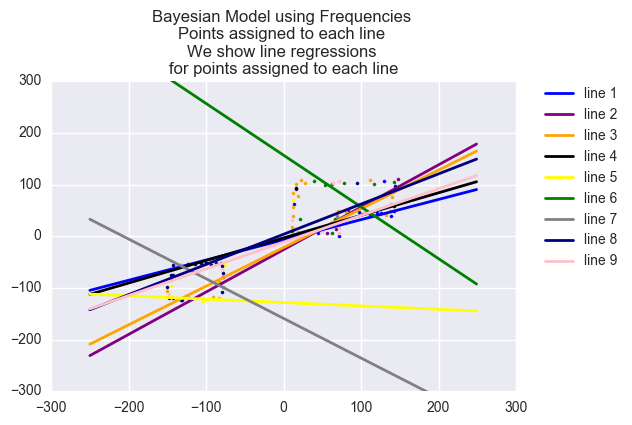

In [145]:
colors = ['red','blue','purple','orange','black','yellow','green','gray','navy','pink']
for l in xrange(L):
    point_ids = line_keys[l]
    ps = []
    for _id in point_ids:
        as_point = point_ind_hash[_id]
        ps.append(as_point)
    ps = np.asarray(ps)
    
    # RANSAC STUFF ########################
    if ps.shape[0] > 1:
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
        model_ransac.fit(ps[:,0:1], ps[:,1:])

        line_X = np.arange(-250, 250)
        line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])
        line_y_ransac = line_y_ransac[:,0]

        plt.plot(line_X, line_y_ransac, color=colors[l], linestyle='-',
             linewidth=2, label='line '+str(l))
    
    #######################################
    
    plt.scatter(ps[:,0], ps[:,1], color=colors[l], marker='.')
plt.title("Bayesian Model using Frequencies \nPoints assigned to each line \nWe show line regressions \nfor points assigned to each line")   
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((-300,300))
plt.show()

## Linear similarity ADDITION


  0%|          | 0/100 [00:00<?, ?it/s]
Exception in thread Thread-38:
Traceback (most recent call last):
  File "/Users/Iris/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py", line 103, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Iris/anaconda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


100%|██████████| 100/100 [00:06<00:00, 18.84it/s]


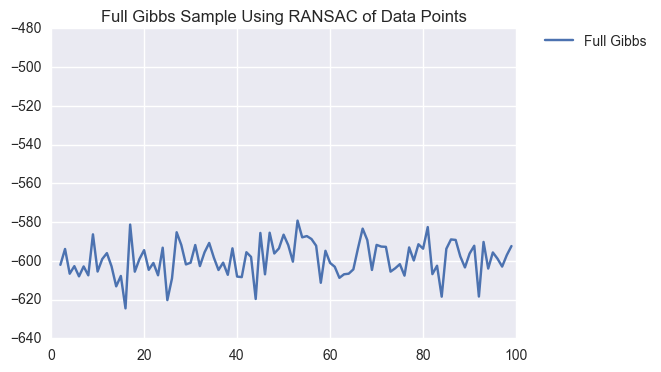

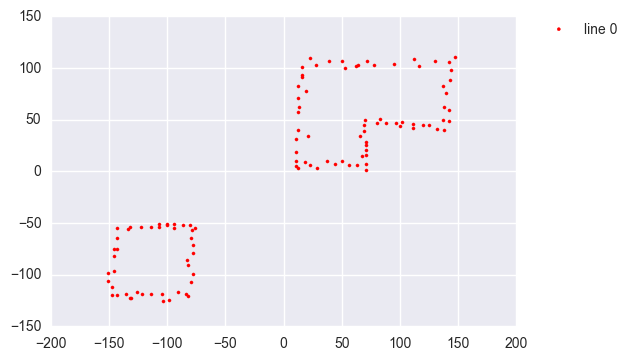

In [173]:
import sys
from numpy.linalg import norm
qs, c = Initialize_qs()

'''Collect statistics'''
c_pl = np.sum(c, axis=0) 
c_yl = np.sum(c, axis=1) 
c_l = np.sum(c_pl, axis=0) 
L_y = np.sum(c_yl, axis=1) 

'''[alpha] [beta] hyperparameters'''
alphas = np.ones((L,1))[:,0] #lines
gammas = np.ones((P,1))[:,0] #points

'''[PI] For each polygon, dirichlet distribution over lines'''
# per-polygon-line distributions: 
pplm = np.zeros((L,Y)) # 10, 2
for y in xrange(Y):
    pplm[:,y] = np.random.dirichlet(alphas + c_yl[y])

    

'''[B] For each line, dirichlet distribution over points'''
# per-line-point distributions: 
lines = np.zeros((P,L)) #113, 10
for l in xrange(L):
    lines[:, l] =  np.random.dirichlet(gammas + c_pl[:,l]) # FREQUENCIES

RUNS = 100
full_gibbs_likelihoods = [] 
for iters in tqdm(range(0,RUNS)):
    # compute data likelihood
    p = compute_data_likelihood(qs, lines)
    
    # store likelihood
    full_gibbs_likelihoods.append(p)
    
    #print "Iter %d, p=%.2f" % (iters,p)
    
    # resample per-point line assignments qs
    qs, c_pl, c_yl = resample_qs(qs, c_pl, c_yl)
 
    # resample per-polygon line mixtures pplm
    for y in xrange(Y):
        pplm[:,y] = np.random.dirichlet(alphas + c_yl[y])
    
    # get line keys !!NEED TO OPTIMIZE!!
    line_keys = {}
    for y in xrange(Y):
        for p in xrange(len(qs[y])):
            as_line = qs[y][p]
            if as_line not in line_keys:
                line_keys[as_line] = []
            point_list = line_keys[as_line]
            point = (polygons[y][p][0],polygons[y][p][1])
            point_list.append(point_hash[point])
            line_keys[as_line] = point_list
    
    #print line_keys
    # resample line
    for l in xrange(L):
        # GETING LINE ASSIGNMENTS FOR POINTS ###########
        if l not in line_keys:
            point_ids = []
        else:
            point_ids = line_keys[l]
        ps = []
        for _id in point_ids:
            as_point = point_ind_hash[_id]
            ps.append(as_point)
        ps = np.asarray(ps)
        
        
        # RANSAC STUFF #################################
        line_weights = np.zeros((P,1))[:,0] #points
        #print ps.shape
        if ps.shape[0] > 1:
            model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
            model_ransac.fit(ps[:,0:1], ps[:,1:])
            line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])
            line_y = line_y_ransac[:,0]
            
#    ============== TRAD LINEAR REGRESSION======================
#             model = linear_model.LinearRegression()
#             model.fit(ps[:,0:1], ps[:,1:])
            
#             line_X = np.arange(-250, 250)
#             line_y = model.predict(line_X[:, np.newaxis])
            
    #====================================      
            
            p1 = np.asarray([-250,line_y[0]]) # left most point of line
            p2 = np.asarray([250,line_y[-1]]) # right most point of line
            
            #BUG NOT THE RIGHT WAY
#             for _id in point_ids:
#                 p3 = np.asarray([point_ind_hash[_id][0],point_ind_hash[_id][1]])
#                 d = norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)
#                 inv_d = 1.0/d
#                 line_weights[_id] = inv_d
                
            for y in xrange(Y):
                for p, hash_p in enumerate(poly_y[y]):
                    p3 = point_ind_hash[hash_p]
                    d = norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)
                    inv_d = 1.0/d
                    line_weights[hash_p] = inv_d
                
            
        line_weights = line_weights/float(np.sum(line_weights))
        #lines[:, l] = np.random.dirichlet(gammas + c_pl[:,l])
        lines[:, l] = np.random.dirichlet(gammas + line_weights)
        
plt.plot(range(RUNS), full_gibbs_likelihoods, label='Full Gibbs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Full Gibbs Sample Using RANSAC of Data Points")
plt.show()


line_keys = {}
for y in xrange(Y):
    for p in xrange(len(qs[y])):
        as_line = qs[y][p]
        if as_line not in line_keys:
            line_keys[as_line] = []
        point_list = line_keys[as_line]
        point = (polygons[y][p][0],polygons[y][p][1])
        point_list.append(point_hash[point])
        line_keys[as_line] = point_list
        
        
colors = ['red','blue','purple','orange','black','yellow','green','gray','navy','pink']
for l in xrange(L):
    if l in line_keys:
        point_ids = line_keys[l]
        ps = []
        for _id in point_ids:
            as_point = point_ind_hash[_id]
            ps.append(as_point)
        ps = np.asarray(ps)
        plt.scatter(ps[:,0], ps[:,1], color=colors[l], marker='.',
                label='line '+str(l))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

x: (44, 1)
y: (44, 1)


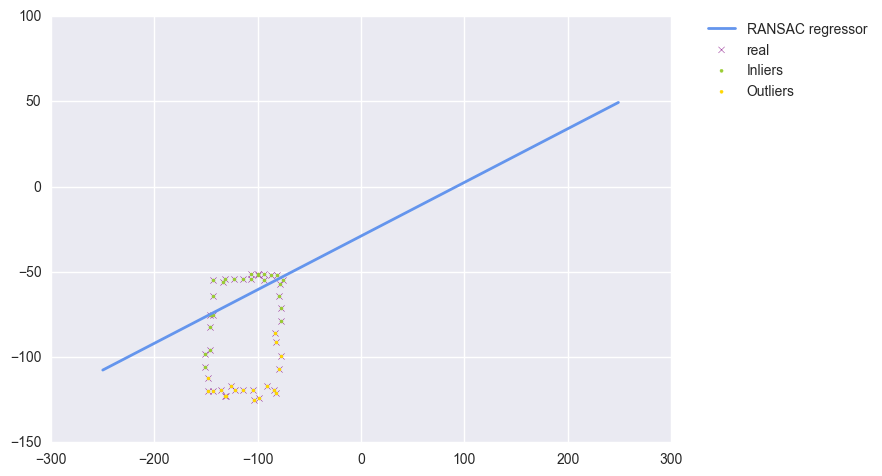

In [21]:
with open("points_hard.dat") as f:
    data = pickle.load(f)

x, y = polygons[0][:,0:1], polygons[0][:,1:]

print "x:", x.shape
print "y:", y.shape

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(x, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(-250, 250)
line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

line_y_ransac = line_y_ransac[:,0]

lw = 2
plt.scatter(x[:,0], y[:,0], color='purple', marker='x',
            label='real')

plt.scatter(x[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(x[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')

#plt.ylim((0,500))
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linestyle='-',
         linewidth=lw, label='RANSAC regressor')
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

100%|██████████| 100/100 [00:01<00:00, 87.26it/s]


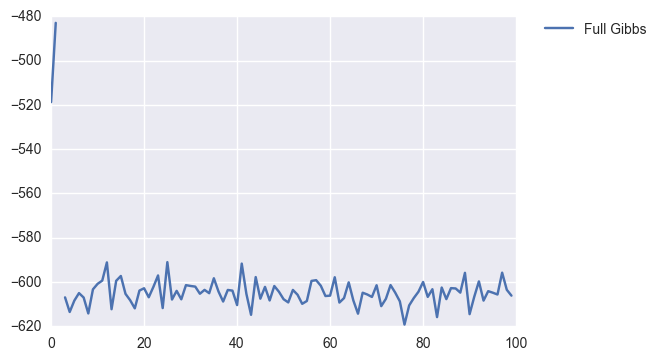

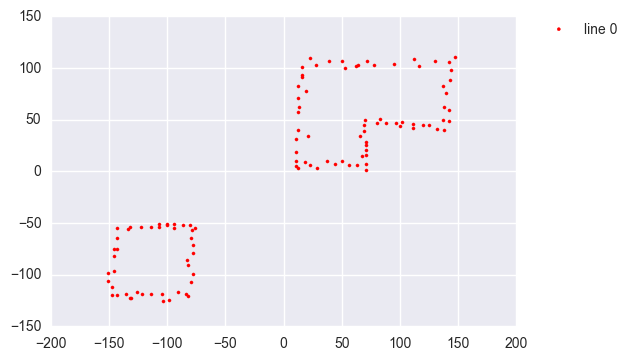

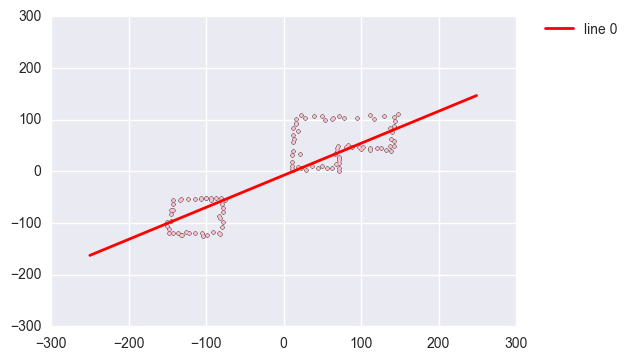

In [157]:
import sys
from numpy.linalg import norm
qs, c = Initialize_qs()

'''Collect statistics'''
c_pl = np.sum(c, axis=0) 
c_yl = np.sum(c, axis=1) 
c_l = np.sum(c_pl, axis=0) 
L_y = np.sum(c_yl, axis=1) 

'''[alpha] [beta] hyperparameters'''
alphas = np.ones((L,1))[:,0] #lines
gammas = np.ones((P,1))[:,0] #points

'''[PI] For each polygon, dirichlet distribution over lines'''
# per-polygon-line distributions: 
pplm = np.zeros((L,Y)) # 10, 2
for y in xrange(Y):
    pplm[:,y] = np.random.dirichlet(alphas + c_yl[y])

    

'''[B] For each line, dirichlet distribution over points'''
# per-line-point distributions: 
lines = np.zeros((P,L)) #113, 10
for l in xrange(L):
    lines[:, l] =  np.random.dirichlet(gammas + c_pl[:,l]) # FREQUENCIES

RUNS = 100
full_gibbs_likelihoods = [] 
for iters in tqdm(range(0,RUNS)):
    # compute data likelihood
    p = compute_data_likelihood(qs, lines)
    
    # store likelihood
    full_gibbs_likelihoods.append(p)
    
    #print "Iter %d, p=%.2f" % (iters,p)
    
    # resample per-point line assignments qs
    qs, c_pl, c_yl = resample_qs(qs, c_pl, c_yl)
 
    # resample per-polygon line mixtures pplm
    for y in xrange(Y):
        pplm[:,y] = np.random.dirichlet(alphas + c_yl[y])
    
    # get line keys !!NEED TO OPTIMIZE!!
    line_keys = {}
    for y in xrange(Y):
        for p in xrange(len(qs[y])):
            as_line = qs[y][p]
            if as_line not in line_keys:
                line_keys[as_line] = []
            point_list = line_keys[as_line]
            point = (polygons[y][p][0],polygons[y][p][1])
            point_list.append(point_hash[point])
            line_keys[as_line] = point_list
    
    #print line_keys
    # resample line
    for l in xrange(L):
        # GETING LINE ASSIGNMENTS FOR POINTS ###########
        if l not in line_keys:
            point_ids = []
        else:
            point_ids = line_keys[l]
        ps = []
        for _id in point_ids:
            as_point = point_ind_hash[_id]
            ps.append(as_point)
        ps = np.asarray(ps)
        
        
        # RANSAC STUFF #################################
        line_weights = np.zeros((P,1))[:,0] #points
        #print ps.shape
        if ps.shape[0] > 1:
#             model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
#             model_ransac.fit(ps[:,0:1], ps[:,1:])
#             line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])
#             line_y_ransac = line_y_ransac[:,0]
#             m = (line_y_ransac[2] - line_y_ransac[1]) / (line_X[2] - line_X[1] + sys.float_info.epsilon)  # slope (gradient) of the line
#             b = model_ransac.estimator_.coef_
            
            model = linear_model.LinearRegression()
            model.fit(ps[:,0:1], ps[:,1:])
            
            line_X = np.arange(-250, 250)
            line_y = model.predict(line_X[:, np.newaxis])
            
#             b = model.coef_
#             m = (line_y[2] - line_y[1]) / (line_X[2] - line_X[1] + sys.float_info.epsilon) 
            
            p1 = np.asarray([-250,line_y[0]]) # left most point of line
            p2 = np.asarray([250,line_y[-1]]) # right most point of line
            
            for _id in point_ids:
                p3 = np.asarray([point_ind_hash[_id][0],point_ind_hash[_id][1]])
                d = norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)
                inv_d = 1.0/d
                line_weights[_id] = inv_d
                
            
        line_weights = line_weights/np.sum(line_weights[_id])
        #lines[:, l] = np.random.dirichlet(gammas + c_pl[:,l])
        lines[:, l] = np.random.dirichlet(gammas + line_weights)
        
plt.plot(range(RUNS), full_gibbs_likelihoods, label='Full Gibbs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

line_keys = {}
for y in xrange(Y):
    for p in xrange(len(qs[y])):
        as_line = qs[y][p]
        if as_line not in line_keys:
            line_keys[as_line] = []
        point_list = line_keys[as_line]
        point = (polygons[y][p][0],polygons[y][p][1])
        point_list.append(point_hash[point])
        line_keys[as_line] = point_list
        
        
colors = ['red','blue','purple','orange','black','yellow','green','gray','navy','pink']
for l in xrange(L):
    if l in line_keys:
        point_ids = line_keys[l]
        ps = []
        for _id in point_ids:
            as_point = point_ind_hash[_id]
            ps.append(as_point)
        ps = np.asarray(ps)
        plt.scatter(ps[:,0], ps[:,1], color=colors[l], marker='.',
                label='line '+str(l))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


colors = ['red','blue','purple','orange','black','yellow','green','gray','navy','pink']
for l in xrange(L):
    if l in line_keys:
        point_ids = line_keys[l]
        ps = []
        for _id in point_ids:
            as_point = point_ind_hash[_id]
            ps.append(as_point)
        ps = np.asarray(ps)

        # RANSAC STUFF ########################
        if ps.shape[0] > 1:
            model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
            model_ransac.fit(ps[:,0:1], ps[:,1:])

            line_X = np.arange(-250, 250)
            line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])
            line_y_ransac = line_y_ransac[:,0]

            plt.plot(line_X, line_y_ransac, color=colors[l], linestyle='-',
                 linewidth=2, label='line '+str(l))

        #######################################

    plt.scatter(ps[:,0], ps[:,1], color=colors[l], marker='.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((-300,300))
plt.show()